# Autoencoders

Thomas Breuel

In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
import seaborn as sns

import torch
from torchmore import flex
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import linalg as LA

device = "cuda:0" if torch.cuda.is_available() else "cpu"

from tutlib.pcaica import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
train_ds = list(datasets.MNIST("data", train=True, download=True, transform=transforms.ToTensor()))
cifar_ds = list(datasets.CIFAR10("data", train=True, download=True, transform=transforms.ToTensor()))
cifar_ds = [(x.mean(0), c) for x, c in cifar_ds]

Files already downloaded and verified


In [3]:
def flatten(xs):
    return xs.view(xs.shape[0], -1)

def mse_train_batch(model, opt, xs, target):
    opt.zero_grad()
    xs = flatten(xs).to(device)
    y = model(xs)
    loss = F.mse_loss(flatten(y), flatten(target).to(device))
    loss.backward()
    opt.step()
    return float(loss)

def train_autoencoder(model, train_ds=train_ds, nepochs=50, batch_size=128, lrs=[0.3, 0.1, 0.03], decay=1e-4, momentum=0.9):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(next(iter(train_dl))[0].shape)
    for lr in lrs:
        opt = optim.SGD(model.parameters(), lr=lr, weight_decay=lr*decay, momentum=momentum)
        for epoch in range(nepochs+1):
            log = []
            for xs, _ in train_dl:
                loss = mse_train_batch(model, opt, xs, xs)
                log.append((loss,))
            loss, = np.mean(log, axis=0)
            if epoch % 10 == 0:
                print(f"{epoch:2d} lr {lr:.2e} loss {loss:.3f}")


In [4]:

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.Linear(100, 784),
).to(device)
train_autoencoder(model, train_ds)
model.eval()

torch.Size([128, 1, 28, 28])
 0 lr 3.00e-01 loss 0.043
10 lr 3.00e-01 loss 0.009
20 lr 3.00e-01 loss 0.007
30 lr 3.00e-01 loss 0.006
40 lr 3.00e-01 loss 0.006
50 lr 3.00e-01 loss 0.006
 0 lr 1.00e-01 loss 0.006
10 lr 1.00e-01 loss 0.006
20 lr 1.00e-01 loss 0.006
30 lr 1.00e-01 loss 0.006
40 lr 1.00e-01 loss 0.006
50 lr 1.00e-01 loss 0.006
 0 lr 3.00e-02 loss 0.006
10 lr 3.00e-02 loss 0.006
20 lr 3.00e-02 loss 0.006
30 lr 3.00e-02 loss 0.006
40 lr 3.00e-02 loss 0.006
50 lr 3.00e-02 loss 0.006


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=784, bias=True)
)

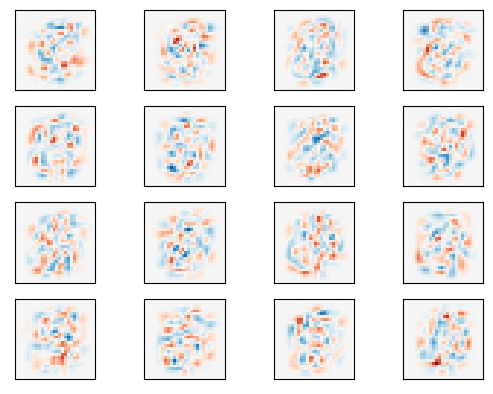

In [5]:
m = model[1].weight.detach().cpu().abs().amax().item()
showgrid(model[1].weight.detach().cpu().numpy().reshape(-1, 28, 28), cmap=cm.RdBu, vmin=-m, vmax=m)

In [6]:
class Noisify(nn.Module):
    def __init__(self, dropout=0.0, noise=0.0, spnoise=0.3):
        super().__init__()
        self.dropout = dropout
        self.noise = noise
        self.spnoise = spnoise
    def forward(self, xs):
        if self.training:
            if self.noise > 0:
                noise = torch.randn_like(xs) * self.noise
                xs = xs + noise
            if self.spnoise > 0:
                spnoise_mask = (torch.rand_like(xs) > self.spnoise).float()
                spnoise_value = (torch.rand_like(xs) > 0.5).float()
                xs = xs * spnoise_mask + spnoise_value * (1-spnoise_mask)
            if self.dropout > 0:
                mask = torch.rand_like(xs) > self.dropout
                xs = xs * mask
            return xs
        else:
            return xs

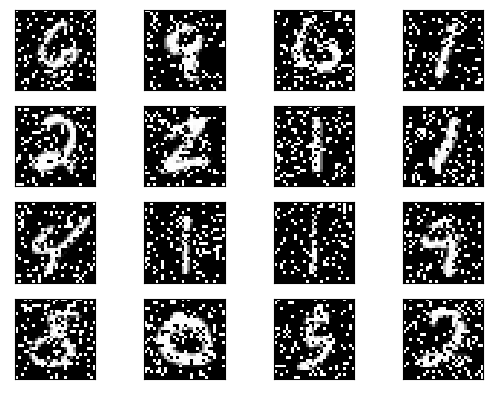

In [7]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
xs, _ = next(iter(train_dl))
ys = Noisify()(xs.view(-1, 784))
showgrid(ys)

In [8]:
model = nn.Sequential(
    nn.Flatten(),
    Noisify(),
    nn.Linear(784, 500),
    nn.Linear(500, 784),
).to(device)
model.train()
train_autoencoder(model, train_ds)

torch.Size([128, 1, 28, 28])
 0 lr 3.00e-01 loss 0.045
10 lr 3.00e-01 loss 0.020
20 lr 3.00e-01 loss 0.020
30 lr 3.00e-01 loss 0.020
40 lr 3.00e-01 loss 0.020
50 lr 3.00e-01 loss 0.020
 0 lr 1.00e-01 loss 0.020
10 lr 1.00e-01 loss 0.020
20 lr 1.00e-01 loss 0.020
30 lr 1.00e-01 loss 0.020
40 lr 1.00e-01 loss 0.020
50 lr 1.00e-01 loss 0.020
 0 lr 3.00e-02 loss 0.020
10 lr 3.00e-02 loss 0.020
20 lr 3.00e-02 loss 0.020
30 lr 3.00e-02 loss 0.020
40 lr 3.00e-02 loss 0.020
50 lr 3.00e-02 loss 0.020


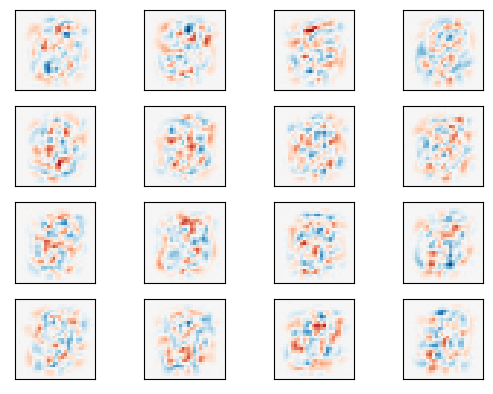

In [9]:
m = model[2].weight.detach().cpu().abs().amax().item()
showgrid(model[2].weight.detach().cpu().numpy().reshape(-1, 28, 28), cmap=cm.RdBu, vmin=-m, vmax=m)

In [10]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32, 100),
    nn.Linear(100, 32*32),
).to(device)
train_autoencoder(model, cifar_ds)
model.eval()

torch.Size([128, 32, 32])
 0 lr 3.00e-01 loss 0.036
10 lr 3.00e-01 loss 0.009
20 lr 3.00e-01 loss 0.007
30 lr 3.00e-01 loss 0.006
40 lr 3.00e-01 loss 0.005
50 lr 3.00e-01 loss 0.005
 0 lr 1.00e-01 loss 0.005
10 lr 1.00e-01 loss 0.005
20 lr 1.00e-01 loss 0.005
30 lr 1.00e-01 loss 0.005
40 lr 1.00e-01 loss 0.005
50 lr 1.00e-01 loss 0.005
 0 lr 3.00e-02 loss 0.005
10 lr 3.00e-02 loss 0.005
20 lr 3.00e-02 loss 0.005
30 lr 3.00e-02 loss 0.005
40 lr 3.00e-02 loss 0.005
50 lr 3.00e-02 loss 0.004


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=100, bias=True)
  (2): Linear(in_features=100, out_features=1024, bias=True)
)

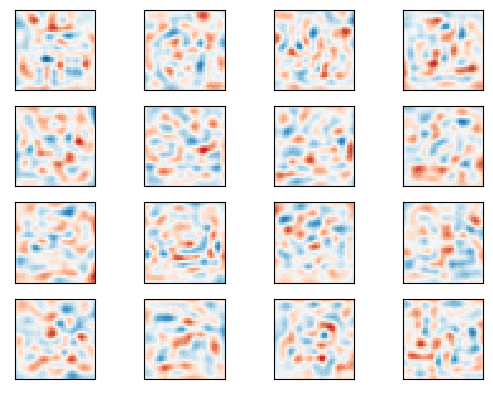

In [11]:
m = model[1].weight.detach().cpu().abs().amax().item()
showgrid(model[1].weight.detach().cpu().numpy().reshape(-1, 32, 32), cmap=cm.RdBu, vmin=-m, vmax=m)

In [12]:
model = nn.Sequential(
    nn.Flatten(),
    Noisify(),
    nn.Linear(32*32, 500),
    nn.Linear(500, 32*32),
).to(device)
model.train()
train_autoencoder(model, cifar_ds)

torch.Size([128, 32, 32])
 0 lr 3.00e-01 loss 0.036
10 lr 3.00e-01 loss 0.013
20 lr 3.00e-01 loss 0.012
30 lr 3.00e-01 loss 0.012
40 lr 3.00e-01 loss 0.012
50 lr 3.00e-01 loss 0.012
 0 lr 1.00e-01 loss 0.012
10 lr 1.00e-01 loss 0.012
20 lr 1.00e-01 loss 0.012
30 lr 1.00e-01 loss 0.012
40 lr 1.00e-01 loss 0.012
50 lr 1.00e-01 loss 0.012
 0 lr 3.00e-02 loss 0.012
10 lr 3.00e-02 loss 0.012
20 lr 3.00e-02 loss 0.012
30 lr 3.00e-02 loss 0.012
40 lr 3.00e-02 loss 0.012
50 lr 3.00e-02 loss 0.012


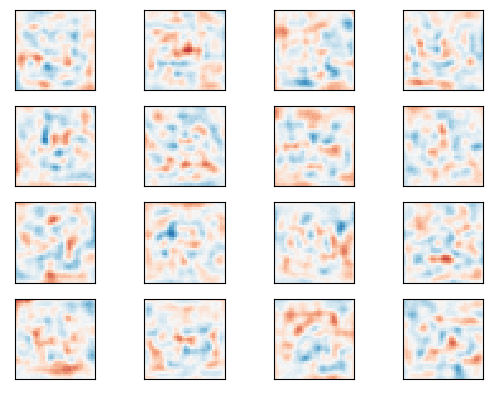

In [13]:
m = model[2].weight.detach().cpu().abs().amax().item()
showgrid(model[2].weight.detach().cpu().numpy().reshape(-1, 32, 32), cmap=cm.RdBu, vmin=-m, vmax=m)